In [ ]:
from google.colab import drive
drive.mount('/Til')

Drive already mounted at /Til; to attempt to forcibly remount, call drive.mount("/Til", force_remount=True).


In [ ]:
!pip install transformers sentencepiece sacrebleu -q

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Mar  2 06:56:18 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    52W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import os
import numpy as np
import pandas as pd
from tqdm.auto import tqdm, trange
import json
import random

In [ ]:
import torch
from transformers import MBartForConditionalGeneration, MBart50Tokenizer

In [ ]:
base_model_path = '/Til/MyDrive/Colab Notebooks/Til/models/qm/mbart-large-52-qm-raw'

In [ ]:
tokenizer = MBart50Tokenizer.from_pretrained(base_model_path)

In [ ]:
old_len = len(tokenizer)
old_len

252291

Because language ids are added by hard-code on initialization, we need to manually fix them.

In [ ]:
tokenizer.lang_code_to_id['qm_XX'] = old_len-1
tokenizer.id_to_lang_code[old_len-1] = 'qm_XX'
tokenizer.fairseq_tokens_to_ids["<mask>"] = len(tokenizer.sp_model) + len(tokenizer.lang_code_to_id) + tokenizer.fairseq_offset

tokenizer.fairseq_tokens_to_ids.update(tokenizer.lang_code_to_id)
tokenizer.fairseq_ids_to_tokens = {v: k for k, v in tokenizer.fairseq_tokens_to_ids.items()}
if 'qm_XX' not in tokenizer.additional_special_tokens:
    tokenizer.additional_special_tokens.append('qm_XX')

In [ ]:
all_sent = pd.read_csv('/Til/MyDrive/Colab Notebooks/Til/Data/Bary_bir_to_model.csv')
all_pairs = list()
for i in range(len(all_sent)):
    all_pairs.append(all_sent.iloc[i].tolist())

In [ ]:
random.choice(all_pairs)

['Менден салам qарачайда, ойра–о, qартлаgа, махтаw болсун jандарча jашлаgа!',
 'Привет от меня старикам, ойра–о, в карачае, хвала таким молоцам, как джандар!']

## Training

In [ ]:
import gc

def cleanup():
    gc.collect()
    torch.cuda.empty_cache()
    
cleanup()

In [ ]:
model = MBartForConditionalGeneration.from_pretrained(base_model_path)

In [ ]:
model.cuda();

### First, update just the new embeddings

In [ ]:
for p in model.parameters():
    p.requires_grad = False
for p in model.model.shared.parameters():
    p.requires_grad = True

In [ ]:
from transformers.optimization import Adafactor
optimizer = Adafactor(
    [p for p in model.parameters() if p.requires_grad], 
    scale_parameter=False, 
    relative_step=False, 
    lr=1e-5,
    clip_threshold=1.0
)

In [ ]:
batch_size = 8  
report_steps = 500 
epochs = 1
losses = []

In [ ]:
tokenizer.src_lang = "qm_XX"
tokenizer.tgt_lang = "ru_RU"

In [ ]:
cleanup()
model.train()

for epoch in range(epochs):
    print('EPOCH', epoch)
    random.shuffle(all_pairs)
    for i in trange(0, int(len(all_pairs) / batch_size)):
        batch = all_pairs[i * batch_size: (i + 1) * batch_size]
        # кодируем вопрос и ответ 
        x = tokenizer([p[1] for p in batch], return_tensors='pt', padding=True, truncation=True, max_length=256).to(model.device)
        with tokenizer.as_target_tokenizer():
            y = tokenizer([p[0] for p in batch], return_tensors='pt', padding=True, truncation=True, max_length=256).to(model.device)
        # -100 - специальное значение, позволяющее не учитывать токены
        y.input_ids[y.input_ids == 0] = -100
        # вычисляем функцию потерь
        try:
            loss = model(
                input_ids=x.input_ids,
                attention_mask=x.attention_mask,
                labels=y.input_ids,
                decoder_attention_mask=y.attention_mask,
                return_dict=True
            ).loss
            # делаем шаг градиентного спуска
            loss.backward()
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)
        except RuntimeError as e:
            print('error')
            loss = None
            optimizer.zero_grad(set_to_none=True)
            cleanup()
            continue

        # печатаем скользящее среднее значение функции потерь
        losses.append(loss.item())
        if i % report_steps == 0:
            print('step', i, 'loss', np.mean(losses[-report_steps:]))

EPOCH 0


  0%|          | 0/3404 [00:00<?, ?it/s]

step 0 loss 2.6382617671489714
step 500 loss 2.5242634286880494
step 1000 loss 2.476305559635162
step 1500 loss 2.4381052548885345
step 2000 loss 2.380168924331665
step 2500 loss 2.2909983100891114
step 3000 loss 2.2936402765512467


Normal translation/paraphrasing loss is typically about 0.5 to 1 in mBART, so here I expect something similar after some fine-tuning.

In [ ]:
save_model_path = '/Til/MyDrive/Colab Notebooks/Til/models/qm/mbart-large-52-ru-qm-v1'

In [ ]:
model.save_pretrained(save_model_path)
tokenizer.save_pretrained(save_model_path)

('/Til/MyDrive/Colab Notebooks/Til/models/qm/mbart-large-52-ru-qm-v1/tokenizer_config.json',
 '/Til/MyDrive/Colab Notebooks/Til/models/qm/mbart-large-52-ru-qm-v1/special_tokens_map.json',
 '/Til/MyDrive/Colab Notebooks/Til/models/qm/mbart-large-52-ru-qm-v1/sentencepiece.bpe.model',
 '/Til/MyDrive/Colab Notebooks/Til/models/qm/mbart-large-52-ru-qm-v1/added_tokens.json')

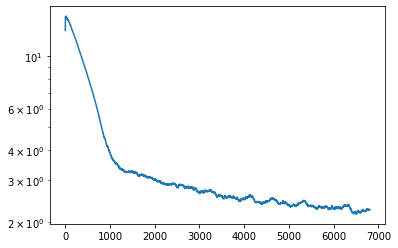

In [ ]:
import matplotlib.pyplot as plt
pd.Series(losses).ewm(100).mean().plot();
plt.yscale('log');

### Now update the whole model, with embeddings and transformer layers.

In [ ]:
loss = None
optimizer.zero_grad(set_to_none=True)
optimizer = None
cleanup()

In [ ]:
for p in model.parameters():
    p.requires_grad = True

In [ ]:
from transformers.optimization import Adafactor
optimizer = Adafactor(
    [p for p in model.parameters() if p.requires_grad], 
    scale_parameter=False, 
    relative_step=False, 
    lr=1e-6,
    clip_threshold=1.0
)

In [ ]:
batch_size = 8
report_steps = 200 
epochs = 10 # 20
losses = []

Optimizing all parameters takes x1.5 longer than just embeddings (4h): about 6h per epoch. 

In [ ]:
cleanup()
model.train()

for epoch in range(epochs):
    print('EPOCH', epoch)
    random.shuffle(all_pairs)
    for i in trange(0, int(len(all_pairs) / batch_size)):
        batch = all_pairs[i * batch_size: (i + 1) * batch_size]
        # кодируем вопрос и ответ 
        x = tokenizer([p[1] for p in batch], return_tensors='pt', padding=True, truncation=True, max_length=256).to(model.device)
        with tokenizer.as_target_tokenizer():
            y = tokenizer([p[0] for p in batch], return_tensors='pt', padding=True, truncation=True, max_length=256).to(model.device)
        # -100 - специальное значение, позволяющее не учитывать токены
        y.input_ids[y.input_ids == 0] = -100
        # вычисляем функцию потерь
        try:
            loss = model(
                input_ids=x.input_ids,
                attention_mask=x.attention_mask,
                labels=y.input_ids,
                decoder_attention_mask=y.attention_mask,
                return_dict=True
            ).loss
            # делаем шаг градиентного спуска
            loss.backward()
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)
        except RuntimeError as e:
            print('error')
            loss = None
            optimizer.zero_grad(set_to_none=True)
            cleanup()
            continue

        # печатаем скользящее среднее значение функции потерь
        losses.append(loss.item())
        if i % report_steps == 0:
            print('step', i, 'loss', np.mean(losses[-report_steps:]))
    model.save_pretrained(save_model_path)
    tokenizer.save_pretrained(save_model_path)

EPOCH 0


  0%|          | 0/3404 [00:00<?, ?it/s]

step 0 loss 1.2027795985341072
step 200 loss 1.213765984773636
step 400 loss 1.2403896549344062
step 600 loss 1.1765132483839988
step 800 loss 1.2169644206762313
step 1000 loss 1.2111477568745612
step 1200 loss 1.1617931696772574
step 1400 loss 1.2129421037435533
step 1600 loss 1.2251999048888684
step 1800 loss 1.242489685714245
step 2000 loss 1.2167922380566596
step 2200 loss 1.211357849240303
step 2400 loss 1.167812866717577
step 2600 loss 1.1698272468149662
step 2800 loss 1.212222776710987
step 3000 loss 1.2151969553530215
step 3200 loss 1.200360694527626
step 3400 loss 1.194363015294075
EPOCH 1


  0%|          | 0/3404 [00:00<?, ?it/s]

step 0 loss 1.1855492514371873
step 200 loss 1.1895286011695863
step 400 loss 1.184159840196371
step 600 loss 1.1594434843957424
step 800 loss 1.2095591481029988
step 1000 loss 1.1928059673309326
step 1200 loss 1.1777685856819153
step 1400 loss 1.1606056477129458
step 1600 loss 1.2040085673332215
step 1800 loss 1.1840113115310669
step 2000 loss 1.1560293330252172
step 2200 loss 1.1817628501355648
step 2400 loss 1.187082460820675
step 2600 loss 1.163109632730484
step 2800 loss 1.1743572920560836
step 3000 loss 1.176040450334549
step 3200 loss 1.112900552302599
step 3400 loss 1.1306720380485058
EPOCH 2


  0%|          | 0/3404 [00:00<?, ?it/s]

step 0 loss 1.136434240192175
step 200 loss 1.1776892051100731
step 400 loss 1.1266632571816444
step 600 loss 1.1531532377004623
step 800 loss 1.1216108982264996
step 1000 loss 1.1277523052692413
step 1200 loss 1.1856360656023026
step 1400 loss 1.1252397419512272
step 1600 loss 1.1186704786121846
step 1800 loss 1.1602937105298041
step 2000 loss 1.1165740689635277
step 2200 loss 1.117839543223381
step 2400 loss 1.1463587008416654
step 2600 loss 1.150892042964697
step 2800 loss 1.1306244187057017
step 3000 loss 1.151439272761345
step 3200 loss 1.1670807407796382
step 3400 loss 1.1086174622178078
EPOCH 3


  0%|          | 0/3404 [00:00<?, ?it/s]

step 0 loss 1.1101220360398292
step 200 loss 1.1022785718739032
step 400 loss 1.1299551433324815
step 600 loss 1.1183580952882766
step 800 loss 1.0951961463689803
step 1000 loss 1.0942546652257443
step 1200 loss 1.0809623491764069
step 1400 loss 1.0719828382134438
step 1600 loss 1.104553470760584
step 1800 loss 1.1045598471164704
step 2000 loss 1.1105818608403206
step 2200 loss 1.1264852967858314
step 2400 loss 1.1436843563616277
step 2600 loss 1.1165164956450462
step 2800 loss 1.1048210203647613
step 3000 loss 1.1247887271642685
step 3200 loss 1.1110679766535758
step 3400 loss 1.1040678250789642
EPOCH 4


  0%|          | 0/3404 [00:00<?, ?it/s]

step 0 loss 1.1054935404658317
step 200 loss 1.0644414442777634
step 400 loss 1.1121938602626324
step 600 loss 1.0620238994061948
step 800 loss 1.102667121589184
step 1000 loss 1.1022355824708938
step 1200 loss 1.0667795073986053
step 1400 loss 1.0814021568000316
step 1600 loss 1.0949597823619843
step 1800 loss 1.1206121326982974
step 2000 loss 1.0390751087665557
step 2200 loss 1.0533825749158858
step 2400 loss 1.0599537782371045
step 2600 loss 1.072780851125717
step 2800 loss 1.0786434787511825
step 3000 loss 1.056115292608738
step 3200 loss 1.0858718667924405
step 3400 loss 1.0494197960197926
EPOCH 5


  0%|          | 0/3404 [00:00<?, ?it/s]

step 0 loss 1.0480404423177243
step 200 loss 1.040110968351364
step 400 loss 1.0605080091953278
step 600 loss 1.08260149538517
step 800 loss 1.0790596681833267
step 1000 loss 1.0522214272618293
step 1200 loss 1.060261398255825
step 1400 loss 1.053113850057125
step 1600 loss 1.0312558268010616
step 1800 loss 1.0747845360636712
step 2000 loss 1.07471265822649
step 2200 loss 1.0557061484456063
step 2400 loss 1.0360986751317978
step 2600 loss 1.0388175791502
step 2800 loss 1.0569228546321392
step 3000 loss 1.045692892372608
step 3200 loss 1.064110725671053
step 3400 loss 1.0221979127824306
EPOCH 6


  0%|          | 0/3404 [00:00<?, ?it/s]

step 0 loss 1.0280347691476346
step 200 loss 1.03315955594182
step 400 loss 1.050517375767231
step 600 loss 1.0322713647782802
step 800 loss 1.0273237502574921
step 1000 loss 1.0086657881736756
step 1200 loss 1.043413440734148
step 1400 loss 1.0376138068735599
step 1600 loss 1.013133799880743
step 1800 loss 1.0386752347648143
step 2000 loss 1.0211686491966248
step 2200 loss 1.0242209665477275
step 2400 loss 1.0272638827562333
step 2600 loss 1.0099998685717582
step 2800 loss 1.0171820470690727
step 3000 loss 1.0188587045669555
step 3200 loss 1.0162385194003583
step 3400 loss 1.0234189368784428
EPOCH 7


  0%|          | 0/3404 [00:00<?, ?it/s]

step 0 loss 1.022628367692232
step 200 loss 0.982928845435381
step 400 loss 1.0122944790124893
step 600 loss 0.9887742272019386
step 800 loss 1.0312775628268718
step 1000 loss 1.00934714153409
step 1200 loss 1.0025865204632283
step 1400 loss 1.0078787207603455
step 1600 loss 1.0006753228604794
step 1800 loss 1.0183994598686694
step 2000 loss 1.0106993743777275
step 2200 loss 1.0094404865801334
step 2400 loss 1.0285269975662232
step 2600 loss 1.0447627413272857
step 2800 loss 0.9937817746400833
step 3000 loss 0.9757021543383598
step 3200 loss 0.9892709827423096
step 3400 loss 0.976570481956005
EPOCH 8


  0%|          | 0/3404 [00:00<?, ?it/s]

step 0 loss 0.9812045571208
step 200 loss 0.9996104800701141
step 400 loss 0.9747659739851952
step 600 loss 0.9753314888477326
step 800 loss 0.9576143032312393
step 1000 loss 0.9872798983752727
step 1200 loss 0.9917900827527046
step 1400 loss 0.9659377165138722
step 1600 loss 0.9540434230864048
step 1800 loss 0.9893585003912448
step 2000 loss 0.9924460981786251
step 2200 loss 0.9691981266438962
step 2400 loss 0.9807422713935375
step 2600 loss 0.9881539852917194
step 2800 loss 0.9785986874997615
step 3000 loss 0.9850867255032063
step 3200 loss 1.014253457635641
step 3400 loss 1.0022749577462673
EPOCH 9


  0%|          | 0/3404 [00:00<?, ?it/s]

step 0 loss 0.9948707617819309
step 200 loss 0.9671373619139194
step 400 loss 0.9696800410747528
step 600 loss 0.9912268970906735
step 800 loss 0.954460636973381
step 1000 loss 0.96763397783041
step 1200 loss 0.9979792250692845
step 1400 loss 0.967960380166769
step 1600 loss 0.9563361963629723
step 1800 loss 0.9830842086672783
step 2000 loss 0.9431382194161415
step 2200 loss 0.9617154881358146
step 2400 loss 0.9320839314162731
step 2600 loss 0.9589830440282822
step 2800 loss 0.9576930668950081
step 3000 loss 0.9526741024851799
step 3200 loss 0.9501883375644684
step 3400 loss 0.9816423545777798


The final loss was about 1.0.

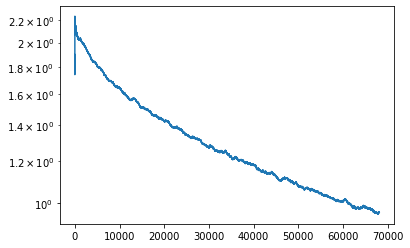

In [ ]:
pd.Series(losses).ewm(1000).mean().plot();
plt.yscale('log');

In [ ]:
model.save_pretrained(save_model_path)
tokenizer.save_pretrained(save_model_path)

('/Til/MyDrive/Colab Notebooks/Til/models/qm/mbart-large-52-ru-qm-v1/tokenizer_config.json',
 '/Til/MyDrive/Colab Notebooks/Til/models/qm/mbart-large-52-ru-qm-v1/special_tokens_map.json',
 '/Til/MyDrive/Colab Notebooks/Til/models/qm/mbart-large-52-ru-qm-v1/sentencepiece.bpe.model',
 '/Til/MyDrive/Colab Notebooks/Til/models/qm/mbart-large-52-ru-qm-v1/added_tokens.json')

In [ ]:
model.eval();

In [ ]:
qm, ru = random.choice(all_pairs)
qm, ru

('Ол эки qарындаш да, айлана, qыдыра барыb, ол qыяwлу qызланы юйлерине qонаqgа тюшдюле.',
 'И эти двое братьев, разъезжаясь, путешествуя, пришли в гости к этим девушкам с недостатками.')

In [ ]:
def translate(text, src='ru_RU', trg='qm_XX', max_length=200, num_beams=5, repetition_penalty=5.0, **kwargs):
    tokenizer.src_lang = src
    encoded = tokenizer(text, return_tensors="pt")
    generated_tokens = model.generate(
        **encoded.to(model.device),
        forced_bos_token_id=tokenizer.lang_code_to_id[trg], 
        max_length=max_length, 
        num_beams=num_beams,
        repetition_penalty=repetition_penalty,
        # early_stopping=True,
    )
    return tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)[0]


In [ ]:
translate(ru)

'qm_XX Ол эки qарындаш да, келе-келе барыb, ол оnсуз qызлаgа qонаqgа келгендиле.'

In [ ]:
loss = None
optimizer.zero_grad(set_to_none=True)
optimizer = None
cleanup()

# Evaluate

In [ ]:
!ls /Til/MyDrive/Colab Notebooks/Til/Data/

dev1000.v1.json			     myv_mono.v1.json  train.v1.json
myv_mono.v1.back_translated.v1.json  test1000.v1.json


In [ ]:
dev_s = pd.read_csv('/Til/MyDrive/Colab Notebooks/Til/Data/Bary_besh_to_model.csv')
dev = list()
for i in range(20):
    dev.append(dev_s.iloc[i].tolist())

In [ ]:
from sacrebleu import CHRF, BLEU
chrf_calc = CHRF(word_order=2)
bleu_calc = BLEU()

ChrF++ is 50, but BLEU is only 18. 

In [ ]:
for k in range(len(dev)):
    s = chrf_calc.corpus_score(translate(dev[k][1]), [dev[k][0]]).score
    print(f'{k} {s:2.2f}')

0 6.42
1 2.72
2 2.43
3 5.07
4 3.11
5 5.31
6 7.79
7 3.87
8 4.22
9 9.54
10 5.72
11 4.79
12 3.54
13 2.07
14 6.16
15 6.51
16 5.38
17 5.44
18 3.03
19 4.19


In [ ]:
print(chrf_calc.corpus_score(
    [t for k in range(len(dev)) for t in translate(dev[k][1])], 
    [[t for k in range(len(dev)) for t in dev[k][0]]]
).score)

4.93618015597161


In [ ]:
translate('Надо купить молоко')

'qm_XX Сютню алыgа керекме'

In [ ]:
qm, ru = random.choice(dev)
qm, ru

('- Бизге бер! – деb ала муну гырjынчыgын бир аwуздан тилегендиле. - Берейим, берейим, сиз да менnе мен айтханны бере эсегиз, - дегенди jаш да. - Айт, не дей эсеn да, берейик, - дегендиле гитче адамчыqла. - Ол сейирлик тирменчигигизни беригиз! – дегенди jаш да. Бергендиле.',
 '- Нам дай! –  они хлеба попросили. - Дам, дам, если дадите мне сказать, - сказал парень. - Говори, что на уме у тебя, даем, - сказали маленькие человечки. - Ту вашу прекрасную мельницу дайте! – сказал парень. Отдали.')

In [ ]:
translate(ru)

'qm_XX - Бизге бер! – деb, ётмекни тилеb тилегендиле. - Дадам, берейик, менnе айтсаgыз десегиз, - деди jаш. - Сюеnде дегениnи айт, берейик, - дедиле адамчыqла. - Ол ариw тирменчиnи бер! – дегенди jаш. Бергендиле.'

# Translate the monolingual corpus for back-translation

**todo: collect a russian monolingual corpus**

In [ ]:
def translate_batch(texts, src='ru_RU', trg='myv_XX', max_length='auto', num_beams=5, repetition_penalty=5.0, **kwargs):
    tokenizer.src_lang = src
    encoded = tokenizer(texts, padding=True, truncation=True, max_length=256, return_tensors="pt")
    if max_length == 'auto':
        max_length = int(10 + encoded.input_ids.shape[1] * 1.5)
    generated_tokens = model.generate(
        **encoded.to(model.device),
        forced_bos_token_id=tokenizer.lang_code_to_id[trg], 
        max_length=max_length, 
        num_beams=num_beams,
        repetition_penalty=repetition_penalty,
        # early_stopping=True,
    )
    return tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)


In [ ]:
translate_batch(all_sentences[:4])

['Приветствую тебя, Хоразин! Приветствую тебя, Бетсаида! Если бы народ Тирский и Сидонский видел чудеса, которые явились вам, то они уже давно одевались в одежду скорби и не сидели бы над кулупами.',
 'Здесь работающих — эти естественные условия, сбор съедобных грибов.',
 'Включает в себя Адамсон Генрих, где открылся Музей чисел Койдула.',
 'Сплыть, девочки!']

In [ ]:
batch_size = 16

In [ ]:
all_translated = []

[]

In [ ]:
cleanup()


for i in trange(0, len(all_sentences), batch_size):
    batch = all_sentences[i: i + batch_size]
    if all_translated[i: i + batch_size]:
        continue
    try:
        all_translated.extend(translate_batch(batch))
    except RuntimeError:
        print('error at', i)
        cleanup()
        bb = []
        for b in batch:
            try:
                bb.append(translate_batch([b])[0])
            except RuntimeError:
                print('mega error!')
                bb.append(b)
                cleanup()
        all_translated.extend(bb)

    if i and (i // batch_size) % 100 == 0:
        with open('/gd/MyDrive/datasets/nlp/myv_corpus/rus_mono.v1.back_translated.v1.json', 'w') as f:
            json.dump({'original': all_sentences, 'translated': all_translated}, f, ensure_ascii=False, indent=2)
        print(i, 'saving...')

  0%|          | 0/20854 [00:00<?, ?it/s]

40000 saving...
41600 saving...
43200 saving...
44800 saving...
46400 saving...
48000 saving...
49600 saving...
51200 saving...
52800 saving...
54400 saving...
56000 saving...
57600 saving...
59200 saving...
60800 saving...
62400 saving...
64000 saving...
65600 saving...
67200 saving...
68800 saving...
70400 saving...
72000 saving...
73600 saving...
75200 saving...
76800 saving...
78400 saving...
80000 saving...
81600 saving...
83200 saving...
84800 saving...
86400 saving...
88000 saving...
89600 saving...
91200 saving...
92800 saving...
94400 saving...
96000 saving...
97600 saving...
99200 saving...
100800 saving...
102400 saving...
104000 saving...
105600 saving...
107200 saving...
108800 saving...
110400 saving...
112000 saving...
113600 saving...
115200 saving...
116800 saving...
118400 saving...
120000 saving...
121600 saving...
123200 saving...
124800 saving...
126400 saving...
128000 saving...
129600 saving...
131200 saving...
132800 saving...
134400 saving...
136000 saving...
1

In [ ]:
with open('/gd/MyDrive/datasets/nlp/myv_corpus/rus_mono.v1.back_translated.v1.json', 'w') as f:
    json.dump({'original': all_sentences, 'translated': all_translated}, f, ensure_ascii=False, indent=2)